In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from scipy import stats
from scipy import interpolate
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import colorcet as cc
import joypy
import matplotlib.colors as mcolors
import umap
%matplotlib inline

In [2]:
def box(data,sublat,sublon,tlat,blat,llon,rlon):
    newdat = data[(data[sublat] <= tlat) & (data[sublat] >= blat) & (data[sublon] >= llon) & (data[sublon] <= rlon)]
    return newdat

In [3]:
def re(data):
    data['Longitude'] = np.where(data['Longitude'] < 0.0, data['Longitude'], data['Longitude'])
    data['Longitude'] = np.where(data['Longitude'] >= 0.0, data['Longitude'], data['Longitude'])
    return data

In [4]:
def GRS(maxlat,minlat,minlon,maxlon,element):
    GRS = r"C:\Users\cgary\OneDrive - Louisiana State University\Desktop\GRS_Unit_Del\{}_GS2010_5x5.txt".format(element)
    grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
    #grs["Latitude"] += 0.5
    #grs["Longitude"] += 0.5
    if element == "Th":
        lab = "{} ppm".format(element)
        lab2 = "{} Sigma".format(element)
        grs.loc[grs[lab] == 9999.999, lab] = 0.0
        grs.loc[grs[lab2] == 9999.999, lab2] = 0.0
        #grs = re(grs)
    else:
        lab = "{} Wt%".format(element)
        lab2 = "{} Sigma".format(element)
        grs.loc[grs[lab] == 9999.999, lab] = 0.0
        grs.loc[grs[lab2] == 9999.999, lab2] = 0.0
        #grs = re(grs)
    #grs = box(grs,'Latitude','Longitude',maxlat,minlat,minlon,maxlon)
    return(grs)

In [5]:
def stt(data,data2): 
    zscore = []
    for i in range(len(data)):
        zscore.append((data.iloc[(i)]-np.mean(data))/(np.sqrt((np.std(data))**2+(data2.iloc[(i)])**2)))
    return zscore

In [6]:
def npr(data):
    for i in range(len(data)):
        if data[i] < 0.68:
            data[i]=0.0
        if data[i] >= 0.68:
            data[i] = 1.0
    return data

In [98]:
def hclnp(data):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    projection = TSNE(perplexity=39).fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=int(np.sqrt(len(cdata))),cluster_selection_method='leaf').fit(projection)
    prob = np.array(hdbscan.probabilities_, dtype=np.float64)
    plt.scatter(projection[:,0], projection[:,1],c=hdbscan.labels_)
    #plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob

In [93]:
def hclnp2(data):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    fit = umap.UMAP(n_neighbors=114)
    projection = fit.fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=39, cluster_selection_method='leaf').fit(projection)
    prob = np.array([hdbscan.probabilities_], dtype=np.float64)
    plt.scatter(projection[:,0], projection[:,1], c=hdbscan.probabilities_)
    plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob

In [9]:
def hclnp3(data):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    principal=PCA(n_components=2)
    principal.fit(cdata)
    projection=principal.transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=int(np.sqrt(len(cdata))),cluster_selection_method='leaf').fit(projection)
    prob = np.array([hdbscan.probabilities_], dtype=np.float64)
    plt.scatter(projection[:,0], projection[:,1], c=hdbscan.probabilities_)
    plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob

In [89]:
def plotn(data, title):
    fig, ax1 = plt.subplots(figsize=(10,5),layout="constrained")
    fig.suptitle(title)
    cmap = plt.get_cmap('Spectral',np.max(data)-np.min(data)+1)
    im1 = ax1.scatter(data['Longitude'],data['Latitude'],c=data['HDB'],vmin = np.min(data['HDB']), vmax = np.max(data['HDB']),cmap=cmap)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.set_title('HDBSCAN Cluster')
    fig.colorbar(im1,label='Grouping Number');
    #ax1.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='r');
    return

In [11]:
def plotn2(data,data2, title):
    fig, ax1 = plt.subplots(figsize=(10,5),layout="constrained")
    fig.suptitle(title)
    #cmap = plt.get_cmap('Spectral',np.max(data)-np.min(data)+1)
    im1 = ax1.scatter(data['Longitude'],data['Latitude'],c=data2)
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('Latitude (°)')
    ax1.set_title('HDBSCAN Probability')
    fig.colorbar(im1,label='Probability');
    #ax1.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='r');
    return

In [12]:
def pr0(data):
    prov0= data[data['HDB']==0.0]
    nprov0 = prov0[prov0['K Wt%'] >0.0]
    nprov0 = nprov0[nprov0['Latitude'] >-35.0]
    nprov01= nprov0[(nprov0['Latitude'] <=-10.0) & (nprov0['Longitude'] <=165.0)]
    nprov011 = nprov01[(nprov01['Longitude'] <-150.0)]
    nprov012 = nprov01[(nprov01['Longitude'] > 100.0)]
    nprov02= nprov0[(nprov0['Latitude'] <=-15.0) & (nprov0['Longitude'] >165.0)]
    nprov0121 = nprov012[(nprov012['Latitude'] <=-20.0) & (nprov012['Longitude'] > 135.0)]
    nprov0122 = nprov012[(nprov012['Latitude'] >=-20.0) ]
    nprov1= nprov0[(nprov0['Latitude'] >-10.0)]
    nprov11= nprov1[(nprov1['Latitude'] >-10.0) & (nprov1['Longitude'] > -85.0) & (nprov1['Longitude'] < 105.0)]
    nprov12= nprov1[(nprov1['Latitude'] <0.0) & (nprov1['Longitude'] > 70.0) & (nprov1['Longitude'] < 155.0)]
    nprov13= nprov1[(nprov1['Latitude'] <-5.0) & (nprov1['Longitude'] < -165.0)]
    list = [nprov011,nprov012,nprov02,nprov0121,nprov0122,nprov11,nprov12,nprov13]
    nprov = pd.concat(list)
    return nprov

In [13]:
def rat(data1,err1,data2,err2):
    median1 = np.quantile(data1, 0.5)  # 0.5 represents the 50th percentile, which is the median
    q11 = np.quantile(data1, 0.25)  # First quartile (25th percentile)
    q31 = np.quantile(data1, 0.75) 
    iqr1 = q31 - q11
    median2 = np.quantile(data2, 0.5)  # 0.5 represents the 50th percentile, which is the median
    q12 = np.quantile(data2, 0.25)  # First quartile (25th percentile)
    q32 = np.quantile(data2, 0.75) 
    iqr2 = q32 - q12
    netmed = median1/median2
    netq1 = q11/q32
    netq3 = q31/q12
    rmse1 =np.sqrt(np.mean(np.square(err1)))
    rmse2 =np.sqrt(np.mean(np.square(err2)))
    err= (median1/median2)*np.sqrt((rmse1/median1)**2+(rmse2/median2)**2) 
    netlw = netmed-err
    nethw = netmed+err
    return(netlw,netq1,netmed,netq3,nethw)

In [14]:
def bp(data1,data2,title):
    ndata2 = data2[data2['Si Wt%'] >0.0]
    t1 = rat(data1['Al Wt%'],data1['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t2 = rat(data1['Si Wt%'],data1['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t3 = rat(data1['Ca Wt%'],data1['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t4 = rat(data1['Fe Wt%'],data1['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t5 = rat(data1['H2O Wt%'],data1['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t6 = rat(data1['S Wt%'],data1['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t7 = rat(data1['Cl Wt%'],data1['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t8 = rat(data1['K Wt%'],data1['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t9 = rat(data1['Th ppm'],data1['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    fig = plt.figure(figsize=(12,6))
    bp=plt.boxplot([t1,t2,t3,t4,t5,t6,t7,t8,t9],showfliers=False)
    plt.xticks([1,2,3,4,5,6,7,8,9], ['Al Wt%','Si Wt%','Ca Wt%','Fe Wt%','H2O Wt%','S Wt%','Cl Wt%','K Wt%','Th ppm'])
    plt.title(title)
    plt.grid()
    plt.axhline(y=1,c='k')
    plt.ylim(0.35,1.85)
    return()

In [15]:
def joyp(data, name, name2,title):
    ndata = data[data[name] >0.0]
    prov0= ndata[ndata['HDB'] == 0.0]
    prov1= ndata[ndata['HDB'] == 1.0]
    prov2= ndata[ndata['HDB'] == 2.0]
    prov3= ndata[ndata['HDB'] == 3.0]
    prov4= ndata[ndata['HDB'] == 4.0]
    prov5= ndata[ndata['HDB'] == 5.0]
    prov6= ndata[ndata['HDB'] == 6.0]
    prov7= ndata[ndata['HDB'] == 7.0]
    labels = ['Mars','Non-Province','Province 1','Province 2','Province 3','Province 4','Province 5','Province 6','Province 7']
    colors = [(0, 0, 0, 1),(1, 0, 1, 1)]# Black for the first segment
    colors.extend(plt.cm.jet_r(np.linspace(0, 1, 7)))  # Remaining colors from jet_r
    new_cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors, N=9)
    lst = list([ndata[name],prov0[name],prov1[name],prov2[name],prov3[name],prov4[name],prov5[name],prov6[name],prov7[name]])
    lst2 = list([ndata[name2],prov0[name],prov1[name2],prov2[name2],prov3[name2],prov4[name2],prov5[name2],prov6[name2],prov7[name2]])
    fig, ax = joypy.joyplot(lst,lst2,labels=labels, grid='x', colormap=new_cmap,title=title,fill=True, kind='kde',figsize=(12,8),xlabels=True, overlap=2, alpha=0.5,normalize=True)
    plt.xlabel(name)    
    return(ax)

In [16]:
def bp2(data1,data3,data2,name1,name2):
    ndata2 = data2[data2['Si Wt%'] >0.0]
    t1 = rat(data1['Al Wt%'],data1['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t2 = rat(data1['Si Wt%'],data1['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t3 = rat(data1['Ca Wt%'],data1['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t4 = rat(data1['Fe Wt%'],data1['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t5 = rat(data1['H2O Wt%'],data1['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t6 = rat(data1['S Wt%'],data1['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t7 = rat(data1['Cl Wt%'],data1['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t8 = rat(data1['K Wt%'],data1['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t9 = rat(data1['Th ppm'],data1['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    t21 = rat(data3['Al Wt%'],data3['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t22 = rat(data3['Si Wt%'],data3['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t23 = rat(data3['Ca Wt%'],data3['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t24 = rat(data3['Fe Wt%'],data3['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t25 = rat(data3['H2O Wt%'],data3['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t26 = rat(data3['S Wt%'],data3['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t27 = rat(data3['Cl Wt%'],data3['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t28 = rat(data3['K Wt%'],data3['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t28 = rat(data3['K Wt%'],data3['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t29 = rat(data3['Th ppm'],data3['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    fig = plt.figure(figsize=(12,6))
    bp1=plt.boxplot([t1,t2,t3,t4,t5,t6,t7,t8,t9],showfliers=False,positions=np.array(range(len([t1,t2,t3,t4,t5,t6,t7,t8,t9])))*2.0-.3, 
                   patch_artist=True, boxprops=dict(facecolor='blue', color='black'), widths=0.6)
    bp2=plt.boxplot([t21,t22,t23,t24,t25,t26,t27,t28,t29],showfliers=False,positions=np.array(range(len([t21,t22,t23,t24,t25,t26,t27,t28,t29])))*2.0+.3, 
                   patch_artist=True, boxprops=dict(facecolor='red', color='black'), widths=0.6)
    plt.xticks([0,2,4,6,8,10,12,14,16], ['Al Wt%','Si Wt%','Ca Wt%','Fe Wt%','H2O Wt%','S Wt%','Cl Wt%','K Wt%','Th ppm'])
    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], [name1, name2])
    plt.grid()
    plt.axhline(y=1,c='k')
    plt.ylim(0.35,1.85)
    return()

In [17]:
def bp3(data1,data3,data4,data2,name1,name2,name3):
    ndata2 = data2[data2['Si Wt%'] >0.0]
    t1 = rat(data1['Al Wt%'],data1['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t2 = rat(data1['Si Wt%'],data1['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t3 = rat(data1['Ca Wt%'],data1['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t4 = rat(data1['Fe Wt%'],data1['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t5 = rat(data1['H2O Wt%'],data1['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t6 = rat(data1['S Wt%'],data1['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t7 = rat(data1['Cl Wt%'],data1['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t8 = rat(data1['K Wt%'],data1['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t9 = rat(data1['Th ppm'],data1['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    t21 = rat(data3['Al Wt%'],data3['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t22 = rat(data3['Si Wt%'],data3['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t23 = rat(data3['Ca Wt%'],data3['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t24 = rat(data3['Fe Wt%'],data3['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t25 = rat(data3['H2O Wt%'],data3['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t26 = rat(data3['S Wt%'],data3['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t27 = rat(data3['Cl Wt%'],data3['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t28 = rat(data3['K Wt%'],data3['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t29 = rat(data3['Th ppm'],data3['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    t31 = rat(data4['Al Wt%'],data4['Al Sigma'],ndata2['Al Wt%'],ndata2['Al Sigma'])
    t32 = rat(data4['Si Wt%'],data4['Si Sigma'],ndata2['Si Wt%'],ndata2['Si Sigma'])
    t33 = rat(data4['Ca Wt%'],data4['Ca Sigma'],ndata2['Ca Wt%'],ndata2['Ca Sigma']) 
    t34 = rat(data4['Fe Wt%'],data4['Fe Sigma'],ndata2['Fe Wt%'],ndata2['Fe Sigma'])
    t35 = rat(data4['H2O Wt%'],data4['H2O Sigma'],ndata2['H2O Wt%'],ndata2['H2O Sigma'])
    t36 = rat(data4['S Wt%'],data4['S Sigma'],ndata2['S Wt%'],ndata2['S Sigma'])
    t37 = rat(data4['Cl Wt%'],data4['Cl Sigma'],ndata2['Cl Wt%'],ndata2['Cl Sigma'])
    t38 = rat(data4['K Wt%'],data4['K Sigma'],ndata2['K Wt%'],ndata2['K Sigma'])
    t39 = rat(data4['Th ppm'],data4['Th Sigma'],ndata2['Th ppm'],ndata2['Th Sigma'])
    fig = plt.figure(figsize=(12,6))
    bp1=plt.boxplot([t1,t2,t3,t4,t5,t6,t7,t8,t9],showfliers=False,positions=np.array(range(len([t1,t2,t3,t4,t5,t6,t7,t8,t9])))*2.0-0.5, 
                   patch_artist=True, boxprops=dict(facecolor='blue', color='black'), widths=0.5)
    bp2=plt.boxplot([t21,t22,t23,t24,t25,t26,t27,t28,t29],showfliers=False,positions=np.array(range(len([t21,t22,t23,t24,t25,t26,t27,t28,t29])))*2.0, 
                   patch_artist=True, boxprops=dict(facecolor='black', color='black'), widths=0.5)
    bp3=plt.boxplot([t31,t32,t33,t34,t35,t36,t37,t38,t39],showfliers=False,positions=np.array(range(len([t31,t32,t33,t34,t35,t36,t37,t38,t39])))*2.0+0.5, 
                   patch_artist=True, boxprops=dict(facecolor='red', color='black'), widths=0.5)
    plt.xticks([0,2,4,6,8,10,12,14,16], ['Al Wt%','Si Wt%','Ca Wt%','Fe Wt%','H2O Wt%','S Wt%','Cl Wt%','K Wt%','Th ppm'])
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], [name1, name2, name3])
    plt.grid()
    plt.axhline(y=1,c='k')
    plt.ylim(0.35,1.85)
    return()

In [18]:
ara1 = pd.read_csv(r"C:\Users\cgary\OneDrive - Louisiana State University\Desktop\GRS_Unit_Del\1_Parker1993_Arabia_Topo.csv",delimiter=',',header=0,index_col=False)
deu1 = pd.read_csv(r"C:\Users\cgary\OneDrive - Louisiana State University\Desktop\GRS_Unit_Del\2_Parker1993_Deuteronilus_Topo.csv",delimiter=',',header=0,index_col=False)

In [19]:
K = GRS(60.0, -60.0, -180.0, 180.0,"K")
Th = GRS(60.0, -60.0, -180.0, 180.0,"Th")
Si = GRS(60.0, -60.0, -180.0, 180.0,"Si")
Fe = GRS(60.0, -60.0, -180.0, 180.0,"Fe")
S = GRS(60.0, -60.0, -180.0, 180.0,"S")
Cl = GRS(60.0, -60.0, -180.0, 180.0,"Cl")
H2O = GRS(60.0, -60.0, -180.0, 180.0,"H2O")
Ca = GRS(60.0, -60.0, -180.0, 180.0,"Ca")
Al = GRS(60.0, -60.0, -180.0, 180.0,"Al")

C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avo

In [20]:
K = K[K['K Wt%'] > 0.0]
Th= Th[Th['Th ppm'] > 0.0]
Si= Si[Si['Si Wt%'] > 0.0]
Fe= Fe[Fe['Fe Wt%'] > 0.0]
S = S[S['S Wt%'] > 0.0]
Cl= Cl[Cl['Cl Wt%'] > 0.0]
H2O= H2O[H2O['H2O Wt%'] > 0.0]
Ca= Ca[Ca['Ca Wt%'] > 0.0]
Al= Al[Al['Al Wt%'] > 0.0]

In [21]:
K['Zscore'] = stt(K['K Wt%'],K['K Sigma'])
S['Zscore'] = stt(S['S Wt%'],S['S Sigma'])
Si['Zscore'] = stt(Si['Si Wt%'],Si['Si Sigma'])
Fe['Zscore'] = stt(Fe['Fe Wt%'],Fe['Fe Sigma'])
Al['Zscore'] = stt(Al['Al Wt%'],Al['Al Sigma'])
Cl['Zscore'] = stt(Cl['Cl Wt%'],Cl['Cl Sigma'])
H2O['Zscore']= stt(H2O['H2O Wt%'],H2O['H2O Sigma'])
Ca['Zscore'] = stt(Ca['Ca Wt%'],Ca['Ca Sigma'])
Th['Zscore'] = stt(Th['Th ppm'],Th['Th Sigma'])

In [22]:
all = [K['Zscore'],Al['Zscore'],Si['Zscore'],Fe['Zscore'],S['Zscore'],Cl['Zscore'],Ca['Zscore'],H2O['Zscore'],Th['Zscore']]

In [23]:
def hclnp(data,perp,size):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    projection = TSNE(perplexity=perp).fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=size,cluster_selection_method='leaf').fit(projection)
    prob = np.array(hdbscan.probabilities_, dtype=np.float64)
    #plt.scatter(projection[:,0], projection[:,1],c=hdbscan.labels_)
    #plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob

In [24]:
def hclnpn(data,perp,size):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    projection = TSNE(perplexity=perp).fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=size).fit(projection)
    prob = np.array(npr(hdbscan.probabilities_), dtype=np.float64)
    #plt.scatter(projection[:,0], projection[:,1],c=hdbscan.labels_)
    #plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    #cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    #cldf2 = cldf[cldf['HDB'] > 0.0]
    return clust

In [28]:
def hclnpn2(data,n,size):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    fit = umap.UMAP(n_neighbors=n)
    projection = fit.fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=39, cluster_selection_method='leaf').fit(projection)
    prob = np.array([hdbscan.probabilities_], dtype=np.float64)
    #plt.scatter(projection[:,0], projection[:,1],c=hdbscan.labels_)
    #plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    #cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    #cldf2 = cldf[cldf['HDB'] > 0.0]
    return clust

In [26]:
x = np.arange(10,101,step=5)
z = np.arange(10,101,step=5)
y=[]
for i in x:
    for j in z:
        y.append(hclnpn(all,i,j))

C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avo

In [29]:
x2 = np.arange(10,101,step=5)
z2 = np.arange(10,101,step=5)
y2=[]
for i in x2:
    for j in z2:
        y2.append(hclnpn2(all,i,j))

C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)
C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avo

In [42]:
def mult(list_of_arrays):

    # Check if all arrays have the same shape:
    first_shape = list_of_arrays[0].shape
    for arr in list_of_arrays:
        if arr.shape != first_shape:
            return None  # Handle different shapes case

    # Initialize the result with the first array:
    result = list_of_arrays[0].copy() # Important: Create a copy to avoid modifying the original list

    # Multiply with the remaining arrays:
    for arr in list_of_arrays[1:]:
        result *= arr  # Element-wise multiplication

    return result

In [131]:
y

[array([1., 1., 1., ..., 2., 2., 2.]),
 array([2., 2., 2., ..., 1., 1., 1.]),
 array([2., 2., 2., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 2., 2., 2.]),
 array([1., 1., 1., ..., 2., 2., 2.]),
 array([1., 1., 1., ..., 4., 4., 4.]),
 array([1., 1., 1., ..., 5., 5., 5.]),
 array([1., 1., 1., ..., 5., 5., 5.]),
 array([0., 0., 0., ..., 3., 3., 3.]),
 array([0., 0., 0., ..., 5., 5., 5.]),
 array([0., 0., 0., ..., 5., 5., 5.]),
 array([0., 0., 0., ..., 3., 3., 3.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([0., 0., 0., ..., 2., 2., 2.]),
 array([1., 1., 1., ..., 5., 5., 5.]),
 array([1., 1., 1., ..., 6., 6., 6.]),
 array([3., 3., 3., ..., 9., 9., 9.]),
 array([3., 3., 3., ..., 8., 8., 8.]),
 array([0., 0., 0., ..., 5., 5., 5.]),
 array([0., 0., 0., ..., 6., 6., 6.]),
 array([0., 0., 0., ..., 

In [77]:
def npr2(data):
    for i in range(len(data)):
        if data[i] <= 0.0:
            data[i]=0.0
        if data[i] > 0.0:
            data[i] = 1.0
    return data

In [133]:
from scipy.stats import zscore
e = np.sum(np.stack(y) , axis=0)
e2 = np.sum(np.stack(y2) , axis=0)

In [ ]:
for i in range(len(y)):
    for j in y[i]:
        print(j)

1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0


In [138]:
e = []
for i in y:
    e.append(y[i] - np.min(y[i])) / (np.max(y[i]) - np.min(y[i]))

TypeError: only integer scalar arrays can be converted to a scalar index

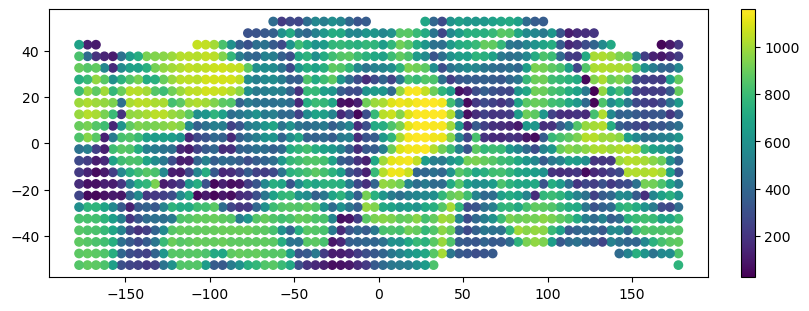

In [130]:
fig = plt.subplots(figsize=(8,3),layout="constrained")
plt.scatter(K['Longitude'],K['Latitude'],c=e)
plt.colorbar();

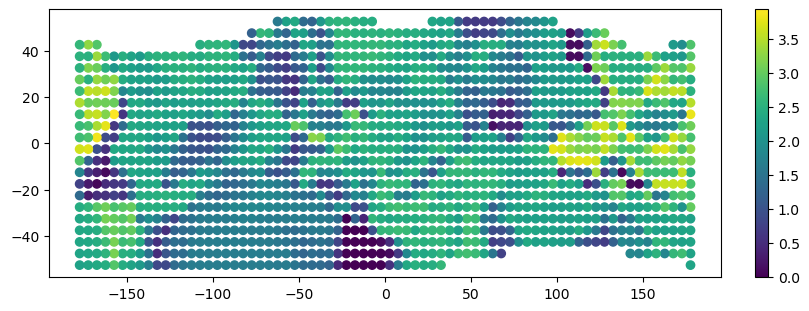

In [132]:
fig = plt.subplots(figsize=(8,3),layout="constrained")
plt.scatter(K['Longitude'],K['Latitude'],c=es)
plt.colorbar();

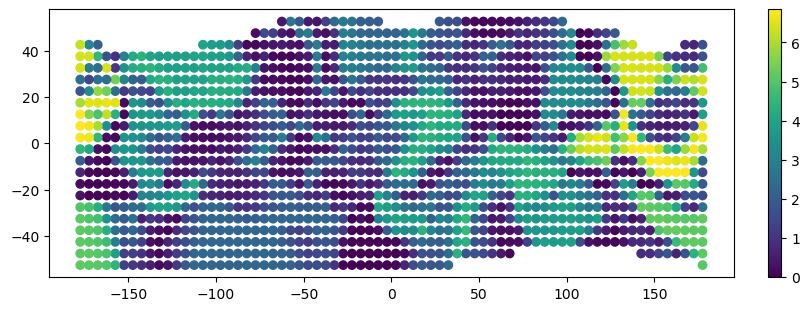

In [125]:
fig = plt.subplots(figsize=(8,3),layout="constrained")
plt.scatter(K['Longitude'],K['Latitude'],c=e2)
plt.colorbar();

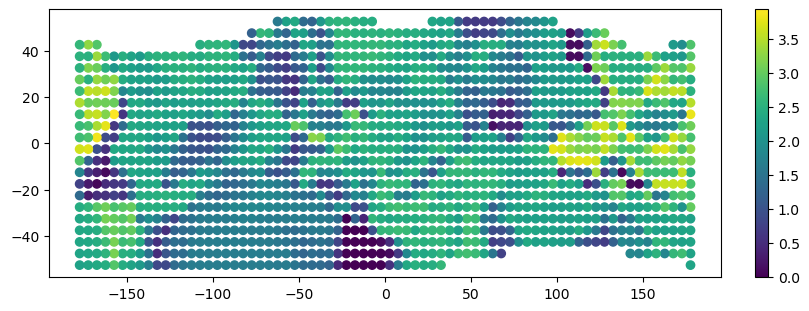

In [126]:
fig = plt.subplots(figsize=(8,3),layout="constrained")
plt.scatter(K['Longitude'],K['Latitude'],c=e2s)
plt.colorbar();

In [115]:
def hclnp(data):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    projection = TSNE(perplexity=60).fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=39,cluster_selection_method='leaf').fit(projection)
    prob = np.array(hdbscan.probabilities_, dtype=np.float64)
    plt.scatter(projection[:,0], projection[:,1],c=hdbscan.labels_)
    #plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob
def hclnp2(data):
    K = GRS(60.0, -60.0, -180.0, 180.0,"K")
    K = K[K['K Wt%'] > 0.0]
    cdata = pd.concat(data, ignore_index=True,axis=1)
    fit = umap.UMAP(n_neighbors=60)
    projection = fit.fit_transform(cdata)
    hdbscan = HDBSCAN(min_cluster_size=39, cluster_selection_method='leaf').fit(projection)
    prob = np.array([hdbscan.probabilities_], dtype=np.float64)
    plt.scatter(projection[:,0], projection[:,1], c=hdbscan.probabilities_)
    plt.colorbar();
    newlab=hdbscan.labels_+1.0
    clust = newlab*npr(hdbscan.probabilities_)
    cldf = pd.DataFrame({'Latitude':K['Latitude'],'Longitude':K['Longitude'],'HDB':clust})
    cldf2 = cldf[cldf['HDB'] > 0.0]
    return cldf,cldf2,prob

C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)


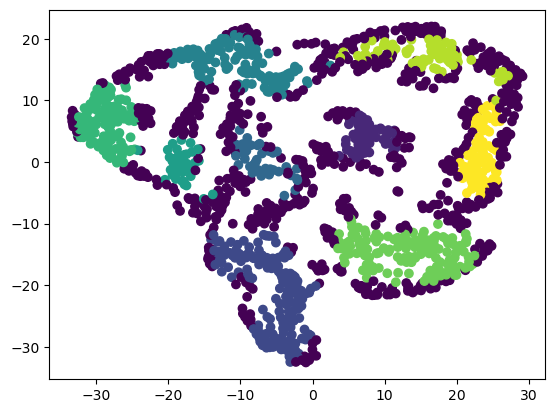

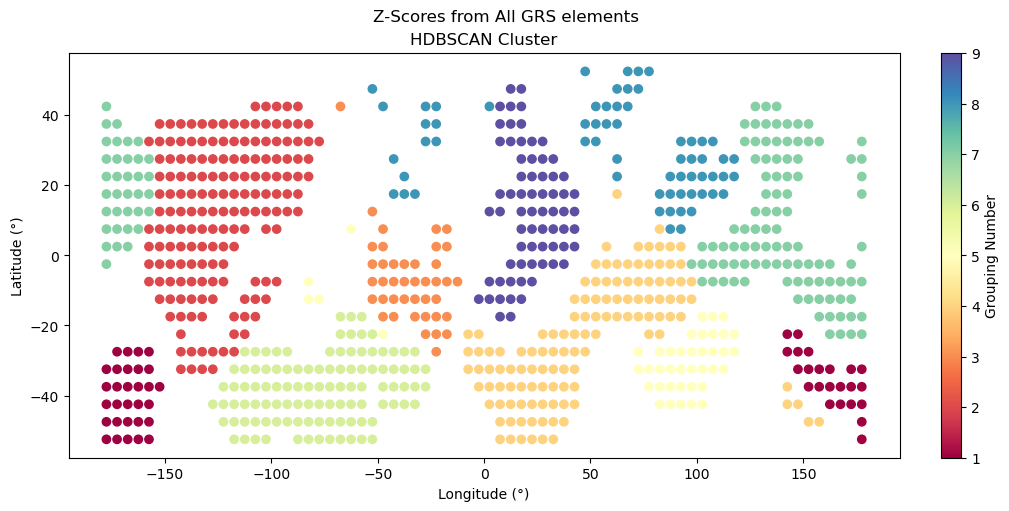

In [116]:
pall = hclnp(all)
testnp = plotn(pall[1], 'Z-Scores from All GRS elements')

C:\Users\cgary\AppData\Local\Temp\ipykernel_23812\667988536.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grs = pd.read_csv(GRS,delimiter='\t+',header=0,index_col=False)


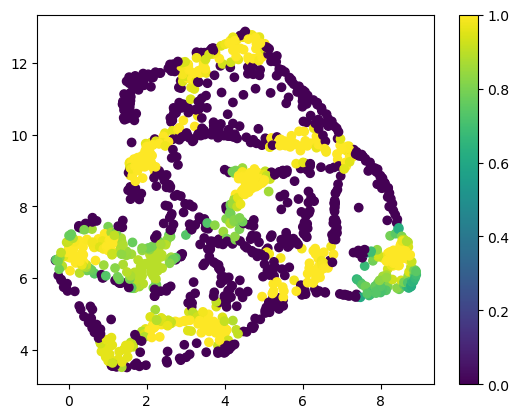

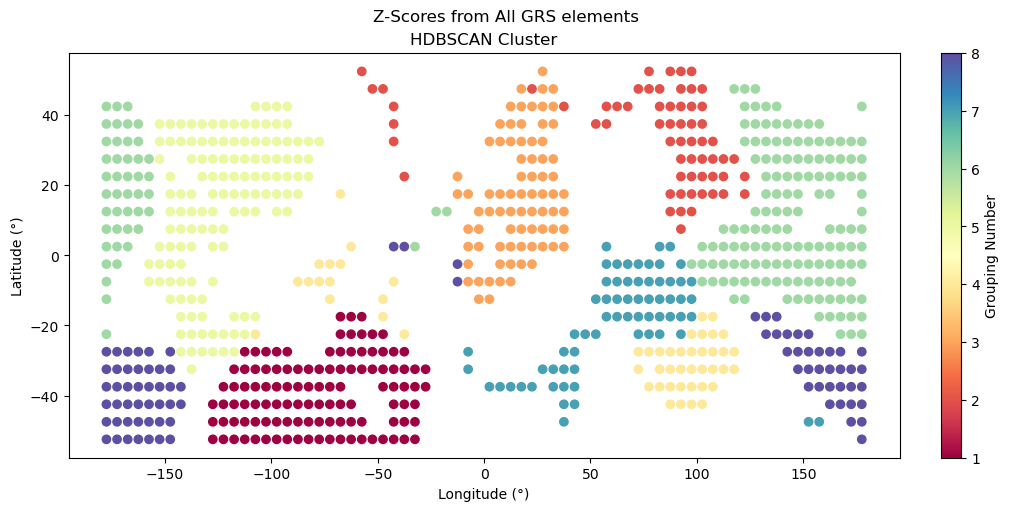

In [117]:
pall2 = hclnp2(all)
testnp = plotn(pall2[1], 'Z-Scores from All GRS elements')

In [ ]:
K = GRS(60.0, -60.0, -180.0, 180.0,"K")
K = K[K['K Wt%'] > 0.0]
shared_columns=['Latitude','Longitude']
missing_rows = K[~K.set_index(shared_columns).index.isin(pall[0].set_index(shared_columns).index)]
missing_rows['HDB']= 0.0
new_df = pd.concat([pall[0], missing_rows],ignore_index=False)
data = stats.binned_statistic_2d(new_df['Latitude'],new_df['Longitude'], values = new_df['HDB'],
                                           statistic='mean', bins = [22,71])
K = K[K['K Wt%'] > 0.0]
data2 = stats.binned_statistic_2d(K['Latitude'],K['Longitude'], values = pall[2],
                                           statistic='mean', bins = [22,71])
masked_data = np.ma.masked_where(data[0] == 0, data[0])
x = new_df['HDB'][new_df['HDB'] > 0]

In [ ]:
fig, ax = plt.subplots(figsize=(13.5,6))
plt.rcParams.update({'font.size': 15})
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5, vmax = np.max(x)+.5,cmap=cmap)
cbar = plt.colorbar(y,label='Province #')
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-87.5,87.5)
plt.xlim(-177.5,177.5);
#plt.scatter(nprov0['Longitude'],nprov0['Latitude'],s=5)

In [ ]:
fig, ax = plt.subplots(figsize=(13.5,6))
plt.rcParams.update({'font.size': 15})
xv,yv = np.meshgrid(data2[2],data2[1])
y = plt.pcolormesh(xv,yv,data2[0],cmap='RdGy_r')
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='c')
cbar = plt.colorbar(y,label='Probability')
#plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
#plt.axis('off')
plt.ylim(-87.5,87.5)
plt.xlim(-177.5,177.5);

In [ ]:
fig = plt.figure(frameon=False)
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5, vmax = np.max(x)+.5,cmap=cmap,fc='none',edgecolors=None,lw=0.01)
#cbar = plt.colorbar(y,label='Group #')
#plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k')
#plt.xlabel('Longitude (°)')
#plt.ylabel('Latitude (°)')
plt.ylim(-87.5,87.5)
plt.xlim(-177.75,177.75)

plt.axis('off');
fig.savefig('provs.png', bbox_inches='tight',transparent=True, pad_inches=0,dpi=300)
#plt.grid(which='both');

In [ ]:
fig = plt.figure(frameon=False)
#fig, ax = plt.subplots(figsize=(13.5,6))
plt.rcParams.update({'font.size': 15})
xv,yv = np.meshgrid(data2[2],data2[1])
y = plt.pcolormesh(xv,yv,data2[0],cmap='RdGy_r')
#cbar = plt.colorbar(y,label='Probability')
#plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k')
#plt.xlabel('Longitude (°)')
#plt.ylabel('Latitude (°)')
plt.axis('off')
plt.ylim(-87.5,87.5)
plt.xlim(-177.5,177.5)
fig.savefig('probs.png', bbox_inches='tight',transparent=True, pad_inches=0,dpi=300);

In [ ]:
fig = plt.figure(frameon=False)
#fig, ax = plt.subplots(figsize=(13.5,6))
plt.rcParams.update({'font.size': 15})
plt.scatter(deu1['Lon'],deu1['Lat'],s=5,label='Parker 1993',c='m')
#cbar = plt.colorbar(y,label='Probability')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='c')
#plt.xlabel('Longitude (°)')
#plt.ylabel('Latitude (°)')
plt.axis('off')
#plt.ylim(-52.5,52.5)
#plt.xlim(-177.5,177.5)
#fig.savefig('shoren2.png', bbox_inches='tight',transparent=True, pad_inches=0,dpi=300);

In [ ]:
K = GRS(60.0, -60.0, -180.0, 180.0,"K")
Th = GRS(60.0, -60.0, -180.0, 180.0,"Th")
Si = GRS(60.0, -60.0, -180.0, 180.0,"Si")
Fe = GRS(60.0, -60.0, -180.0, 180.0,"Fe")
S = GRS(60.0, -60.0, -180.0, 180.0,"S")
Cl = GRS(60.0, -60.0, -180.0, 180.0,"Cl")
H2O = GRS(60.0, -60.0, -180.0, 180.0,"H2O")
Ca = GRS(60.0, -60.0, -180.0, 180.0,"Ca")
Al = GRS(60.0, -60.0, -180.0, 180.0,"Al")

In [ ]:
new_df['K Wt%'] = K['K Wt%']
new_df['K Sigma'] = K['K Sigma']
new_df['Th ppm'] = Th['Th ppm']
new_df['Th Sigma'] = Th['Th Sigma']
new_df['Si Wt%'] = Si['Si Wt%']
new_df['Si Sigma'] = Si['Si Sigma']
new_df['Fe Wt%'] = Fe['Fe Wt%']
new_df['Fe Sigma'] = Fe['Fe Sigma']
new_df['S Wt%'] = S['S Wt%']
new_df['S Sigma'] = S['S Sigma']
new_df['Cl Wt%'] = Cl['Cl Wt%']
new_df['Cl Sigma'] = Cl['Cl Sigma']
new_df['H2O Wt%'] = H2O['H2O Wt%']
new_df['H2O Sigma'] = H2O['H2O Sigma']
new_df['Ca Wt%'] = Ca['Ca Wt%']
new_df['Ca Sigma'] = Ca['Ca Sigma']
new_df['Al Wt%'] = Al['Al Wt%']
new_df['Al Sigma'] = Al['Al Sigma']

In [ ]:
prov1= new_df[new_df['HDB'] == 1.0]
prov2= new_df[new_df['HDB'] == 2.0]
prov3= new_df[new_df['HDB'] == 3.0]
prov4= new_df[new_df['HDB'] == 4.0]
prov5= new_df[new_df['HDB'] == 5.0]
prov6= new_df[new_df['HDB'] == 6.0]
prov7= new_df[new_df['HDB'] == 7.0]
prov0= new_df[new_df['HDB'] == 0.0]
nprov0 = prov0[prov0['K Wt%'] >0.0]

In [ ]:
test = bp(nprov0,new_df,'Non-Province')

In [ ]:
test = bp(prov1,new_df,'Province 1')

In [ ]:
test = bp(prov2,new_df,'Province 2')

In [ ]:
test = bp(prov3,new_df,'Province 3')

In [ ]:
test = bp(prov4,new_df,'Province 4')

In [ ]:
test = bp(prov5,new_df,'Province 5')

In [ ]:
test = bp(prov6,new_df,'Province 6')

In [ ]:
test = bp(prov7,new_df,'Province 7')

In [ ]:
test=joyp(new_df, 'Si Wt%', 'Si Sigma', 'Silicon')

In [ ]:
test=joyp(new_df, 'Al Wt%', 'Al Sigma','Aluminium')

In [ ]:
test=joyp(new_df, 'Ca Wt%', 'Ca Sigma', 'Calcium')

In [ ]:
test=joyp(new_df, 'Fe Wt%','Fe Sigma', 'Iron')

In [ ]:
test=joyp(new_df, 'H2O Wt%','H2O Sigma', 'Water')

In [ ]:
test=joyp(new_df, 'S Wt%','S Sigma', 'Sulphur')

In [ ]:
test=joyp(new_df, 'Cl Wt%', 'Cl Sigma','Chlorine')

In [ ]:
test=joyp(new_df, 'K Wt%','K Sigma', 'Potassium')

In [ ]:
test=joyp(new_df, 'Th ppm','Th Sigma', 'Thorium')

In [ ]:
n1prov4 = prov4[(prov4['Latitude'] > 30.0)]
n2prov4 = prov4[(prov4['Longitude'] < 0.0) & (prov4['Latitude'] > 25.0)]
naprov4 = pd.concat((n1prov4,n2prov4))
nbprov4= prov4.merge(naprov4, how='left', indicator=True)
nbprov4 = nbprov4[nbprov4['_merge'] == 'left_only']

In [ ]:
naprov3 = prov3[(prov3['Longitude'] > 0.0)]
nbprov3 = prov3[(prov3['Longitude'] < 0.0)]

In [ ]:
naprov6a = prov6[(prov6['Longitude'] > 0.0) & (prov6['Latitude'] < 25.0)]
naprov6b = prov6[(prov6['Longitude'] < -100.0)]
naprov6 = pd.concat((naprov6a,naprov6b))
nbprov6 = prov6[(prov6['Longitude'] < 0.0) & (prov6['Longitude'] > -100.0) & (prov6['Latitude'] < 25.0)]
ncprov6 = prov6[(prov6['Latitude'] > 25.0)]

In [ ]:
naprov1= prov1[(prov1['Latitude'] < 15.0)]
nbprov1= prov1[(prov1['Latitude'] > 15.0)]
plt.scatter(naprov1['Longitude'],naprov1['Latitude'],c='red')
plt.scatter(nbprov1['Longitude'],nbprov1['Latitude'],c='blue')
plt.ylim(-90,90)
plt.xlim(-177.5,177.5)

In [ ]:
test = bp2(naprov1,nbprov1,new_df,'Province 1a', 'Province 1b')

In [ ]:
test = bp2(nbprov4,naprov1,new_df,'Province 4b', 'Province 1a')

In [ ]:
#plt.scatter(naprov4['Longitude'],naprov4['Latitude'])
#plt.scatter(nbprov4['Longitude'],nbprov4['Latitude'])
plt.scatter(naprov3['Longitude'],naprov3['Latitude'],c='blue')
plt.scatter(nbprov3['Longitude'],nbprov3['Latitude'],c='red')
plt.ylim(-90,90)
plt.xlim(-177.5,177.5)
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k');

In [ ]:
test = bp2(naprov3,nbprov3,new_df,'Province 3a', 'Province 3b')

In [ ]:
plt.scatter(naprov4['Longitude'],naprov4['Latitude'],c='blue')
plt.scatter(nbprov4['Longitude'],nbprov4['Latitude'],c='red')
plt.ylim(-90,90)
plt.xlim(-177.5,177.5)
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k');

In [ ]:
test = bp2(naprov3,naprov4,new_df,'Province 3a','Province 4a')

In [ ]:
test = bp2(prov7,ncprov6,new_df,'Province 6c','Province 7')

In [ ]:
test = bp2(naprov4,nbprov4,new_df,'Province 4a','Province 4b')

In [ ]:
plt.scatter(naprov6['Longitude'],naprov6['Latitude'],c='blue')
plt.scatter(nbprov6['Longitude'],nbprov6['Latitude'],c='black')
plt.scatter(ncprov6['Longitude'],ncprov6['Latitude'],c='red')
#plt.scatter(naprov3['Longitude'],naprov3['Latitude'])
#plt.scatter(nbprov3['Longitude'],nbprov3['Latitude'])
plt.ylim(-90,90)
plt.xlim(-177.5,177.5)
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k');

In [ ]:
test = bp3(naprov6,nbprov6,ncprov6,new_df,'Province 6a','Province 6b','Province 6c')

In [ ]:
plt.scatter(ncprov6['Longitude'],ncprov6['Latitude'],color='blue')
plt.scatter(nbprov3['Longitude'],nbprov3['Latitude'],color='black')
plt.scatter(naprov4['Longitude'],naprov4['Latitude'],color='red')
#plt.scatter(nbprov3['Longitude'],nbprov3['Latitude'])
plt.ylim(-90,90)
plt.xlim(-177.5,177.5)
plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='k');

In [ ]:
test = bp3(ncprov6,nbprov3,naprov4,new_df,'Province 6c','Province 3b','Province 4a')

In [ ]:
t = Th['Th ppm'][Th['Th ppm']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Th['Longitude'],Th['Latitude'],Th['Th ppm'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='Th ppm')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
#plt.scatter(ara1['Lon'],ara1['Lat'],s=1,label='Parker 1993',c='orange')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = K['K Wt%'][K['K Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
z = plt.tricontourf(K['Longitude'],K['Latitude'],K['K Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
plt.colorbar(z,label='K Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = Si['Si Wt%'][Si['Si Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Si['Longitude'],Si['Latitude'],Si['Si Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='Si Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = Fe['Fe Wt%'][Fe['Fe Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Fe['Longitude'],Fe['Latitude'],Fe['Fe Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='Fe Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = Al['Al Wt%'][Al['Al Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Al['Longitude'],Al['Latitude'],Al['Al Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='Al Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = Ca['Ca Wt%'][Ca['Ca Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Ca['Longitude'],Ca['Latitude'],Ca['Ca Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.015)
plt.colorbar(z,label='Ca Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = S['S Wt%'][S['S Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(S['Longitude'],S['Latitude'],S['S Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='S Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = Cl['Cl Wt%'][Cl['Cl Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(Cl['Longitude'],Cl['Latitude'],Cl['Cl Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01,)
plt.colorbar(z,label='Cl Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
t = H2O['H2O Wt%'][H2O['H2O Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
z = plt.tricontourf(H2O['Longitude'],H2O['Latitude'],H2O['H2O Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5,cmap=cmap, vmax = np.max(x)+.5,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='H2O Wt%')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,label='Parker 1993',c='k')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-52.5,52.5)
plt.xlim(-177.75,177.75);

In [ ]:
def ire(data):
    data['Lon'] = np.where(data['Lon'] > 180.0, data['Lon']-360.0, data['Lon'])
    return data

In [ ]:
thu = pd.read_csv('th_sr_5x5.tab',delimiter='\s+',header=None,index_col=False,names=['Lat','Lon','Th ppm','Sigma','Sigma_CFS'])
thu = ire(thu)

In [ ]:
ks = pd.read_csv('k_sr_5x5.tab',delimiter='\s+',header=None,index_col=False,names=['Lat','Lon','K Wt%','Sigma','Sigma_CFS'])
ks = ire(ks)

In [ ]:
t = ks['K Wt%'][ks['K Wt%']>0.0]
fig = plt.figure(figsize=(13,5.5))
z = plt.tricontourf(ks['Lon'],ks['Lat'],ks['K Wt%'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5, vmax = np.max(x)+.5,cmap=cmap,fc='none',edgecolors=None,lw=0.01)
plt.colorbar(z,label='K Wt%')
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,c='k')
plt.scatter(delto['Lon. (E)'],delto['Lat.'],c='m',marker='s',label='Open Basin Deltas')
plt.scatter(deltc['Lon. (E)'],deltc['Lat.'],c='c',marker='D',label='Closed Basin Deposits')
plt.scatter(deltcs['Lon. (E)'],deltcs['Lat.'],c='green',marker='^',label='Closed Basin Deltas')
ax = plt.gca()
ax.set_facecolor('xkcd:dark navy')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.legend()
plt.ylim(-87.5,87.5)
plt.xlim(-177.5,177.5);

In [ ]:
delto = delt[delt['Basin4']=='O']
deltc = delt[delt['Basin4']=='C']
deltcs = delt[delt['Basin4']=='C(S)']

In [ ]:
t = thu['Th ppm'][thu['Th ppm']>0.0]
fig = plt.figure(figsize=(13,5.5))
z = plt.tricontourf(thu['Lon'],thu['Lat'],thu['Th ppm'],levels=np.linspace(t.min(),t.max(),25),cmap='seismic')
xv,yv = np.meshgrid(data[2],data[1])
cmap = plt.get_cmap('jet_r',int(np.max(x))-int(np.min(x))+1)
#y = plt.pcolormesh(xv,yv,masked_data,vmin = np.min(x)-.5, vmax = np.max(x)+.5,cmap=cmap,fc='none',edgecolors=None,lw=0.01)
plt.scatter(ara1['Lon'],ara1['Lat'],s=5,c='k')
plt.colorbar(z,label='Th ppm')
ax = plt.gca()
plt.scatter(delto['Lon. (E)'],delto['Lat.'],c='m',marker='s',label='Open Basin Deltas')
plt.scatter(deltc['Lon. (E)'],deltc['Lat.'],c='c',marker='D',label='Closed Basin Deposits')
plt.scatter(deltcs['Lon. (E)'],deltcs['Lat.'],c='green',marker='^',label='Closed Basin Deltas')
plt.legend()
ax.set_facecolor('xkcd:dark navy')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.ylim(-87.5,87.5)
plt.xlim(-177.5,177.5);